## License

Copyright 2021 - 2025 Patrick Hall (jphall@gwu.edu), Bhuwan Gupta (bhuwang@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

*DISCLAIMER*: This notebook is not legal or compliance advice.

#### DNSC 6330 - Responsible Machine Learning
Assignment 5

Submission by: Bhuwan Gupta (Group 7)

# Assignment 5 Template

#### Install required libraries

In [ ]:
!pip install interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 56.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━

#### Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
# may need to be updated to location on your drive
%cd drive/My\ Drive/DNSC_6330_Software/assignments/
%ls

Mounted at /content/drive/
/content/drive/My Drive/DNSC_6330_Software/assignments
assign_1_template.ipynb  assign_4_template.ipynb
assign_2_template.ipynb  assign_5_template.ipynb
assign_3_template.ipynb  assign_5_template_original.ipynb


#### Imports and inits

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier      # interpret ebm class
from interpret.perf import ROC                                    # ROC measure for ebm
import numpy as np                                                # for basic array manipulation
import pandas as pd                                               # for dataframe manipulation
import time                                                       # for timers

# plotting functionality
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # necessary for custom legends

# display plots in notebook
%matplotlib inline

# set numpy random seed for better reproducibility
SEED = 12345
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

#### Start global timer

In [ ]:
tic = time.time()

#### Import data

In [ ]:
data = pd.read_csv('../data/hmda_train_preprocessed.csv')

#### Assign basic modeling roles

In [ ]:
y_name = 'high_priced'

## Fit interpretable model

#### Split data into train and validation partitions

In [ ]:
np.random.seed(SEED)  # Ensure reproducibility for this split

split_ratio = 0.7  # 70%/30% train/validation split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Explainable Boosting Machine

#### Retrain most accurate model above 0.8 AIR to debug

In [ ]:
# Create deep copies to add interaction terms
train_copy = train.copy(deep=True)
valid_copy = valid.copy(deep=True)

# Add interaction terms to enhance feature set
train_copy['loan_to_value_loan_amount'] = train_copy['loan_to_value_ratio_std'] * train_copy['loan_amount_std']
valid_copy['loan_to_value_loan_amount'] = valid_copy['loan_to_value_ratio_std'] * valid_copy['loan_amount_std']
train_copy['debt_to_income_ratio_squared'] = train_copy['debt_to_income_ratio_std'] ** 2
valid_copy['debt_to_income_ratio_squared'] = valid_copy['debt_to_income_ratio_std'] ** 2
train_copy['intro_rate_ltv'] = train_copy['intro_rate_period_std'] * train_copy['loan_to_value_ratio_std']
valid_copy['intro_rate_ltv'] = valid_copy['intro_rate_period_std'] * valid_copy['loan_to_value_ratio_std']
train_copy['property_value_income'] = train_copy['property_value_std'] * train_copy['income_std']
valid_copy['property_value_income'] = valid_copy['property_value_std'] * valid_copy['income_std']
train_copy['property_value_debt_to_income'] = train_copy['property_value_std'] * train_copy['debt_to_income_ratio_std']
valid_copy['property_value_debt_to_income'] = valid_copy['property_value_std'] * valid_copy['debt_to_income_ratio_std']

# Update feature list to include interaction terms
rem_x_names = ['property_value_std',
               'no_intro_rate_period_std',
               'loan_amount_std',
               'income_std',
               'conforming',
               'intro_rate_period_std',
               'debt_to_income_ratio_std',
               'term_360',
               'loan_to_value_loan_amount',
               'debt_to_income_ratio_squared',
               'intro_rate_ltv',
               'property_value_income',
               'property_value_debt_to_income']

# Feature selection: Manually check for high correlation (>0.95) and remove redundant features
correlation_matrix = train_copy[rem_x_names].corr().abs()
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
rem_x_names = [col for col in rem_x_names if col not in to_drop]
print(f'Removed features due to high correlation (>0.95): {to_drop}')
print(f'Final rem_x_names after feature selection: {rem_x_names}')

# Define focused parameter grid with increased capacity
param_grid = {
    'learning_rate': [0.0100, 0.0101, 0.0102],  # Expanded around previous best values
    'interactions': [24, 25, 26],
    'outer_bags': [15, 16],
    'max_leaves': [3, 4],  # Reverted to include previous best value
    'min_samples_leaf': [5]  # Fixed at optimal value
}

# Number of random combinations to try
n_combinations = 6  # Increased from 4 to 6 for more thorough search

# Base parameters
base_params = {
    'max_bins': 512,
    'max_interaction_bins': 32,
    'inner_bags': 0,
    'validation_size': 0.25,
    'early_stopping_rounds': 100,
    'n_jobs': NTHREAD,
    'random_state': SEED
}

best_auc = 0
best_params = None

# Perform random search for hyperparameter tuning
np.random.seed(SEED)
for _ in range(n_combinations):
    lr = float(np.random.choice(param_grid['learning_rate']))
    interactions = int(np.random.choice(param_grid['interactions']))
    outer_bags = int(np.random.choice(param_grid['outer_bags']))
    max_leaves = int(np.random.choice(param_grid['max_leaves']))
    min_samples_leaf = int(np.random.choice(param_grid['min_samples_leaf']))

    current_params = base_params.copy()
    current_params.update({
        'learning_rate': lr,
        'interactions': interactions,
        'outer_bags': outer_bags,
        'max_leaves': max_leaves,
        'min_samples_leaf': min_samples_leaf
    })

    ebm = ExplainableBoostingClassifier(**current_params)
    ebm.fit(train_copy[rem_x_names], train_copy[y_name])

    perf = ROC(ebm.predict_proba).explain_perf(valid_copy[rem_x_names], valid_copy[y_name])
    auc = perf._internal_obj['overall']['auc']

    if auc > best_auc:
        best_auc = auc
        best_params = current_params
        print(f'New best AUC: {auc:.4f} with params: {best_params}')

print(f'Best parameters found: {best_params}')
print(f'Best AUC: {best_auc:.4f}')

# Update rem_params with the best parameters
rem_params = best_params

# Ensure integer parameters
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])
rem_params['early_stopping_rounds'] = int(rem_params['early_stopping_rounds'])

# Update train and valid with interaction terms
train = train_copy
valid = valid_copy

# Retrain the base model with best parameters
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name])
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Removed features due to high correlation (>0.95): []
Final rem_x_names after feature selection: ['property_value_std', 'no_intro_rate_period_std', 'loan_amount_std', 'income_std', 'conforming', 'intro_rate_period_std', 'debt_to_income_ratio_std', 'term_360', 'loan_to_value_loan_amount', 'debt_to_income_ratio_squared', 'intro_rate_ltv', 'property_value_income', 'property_value_debt_to_income']
New best AUC: 0.8242 with params: {'max_bins': 512, 'max_interaction_bins': 32, 'inner_bags': 0, 'validation_size': 0.25, 'early_stopping_rounds': 100, 'n_jobs': 4, 'random_state': 12345, 'learning_rate': 0.0102, 'interactions': 25, 'outer_bags': 16, 'max_leaves': 4, 'min_samples_leaf': 5}
New best AUC: 0.8245 with params: {'max_bins': 512, 'max_interaction_bins': 32, 'inner_bags': 0, 'validation_size': 0.25, 'early_stopping_rounds': 100, 'n_jobs': 4, 'random_state': 12345, 'learning_rate': 0.0102, 'interactions': 25, 'outer_bags': 16, 'max_leaves': 3, 'min_samples_leaf': 5}
Best parameters found:

## Sensitivity Analysis: Stress Testing

#### Simulate recession conditions in validation data

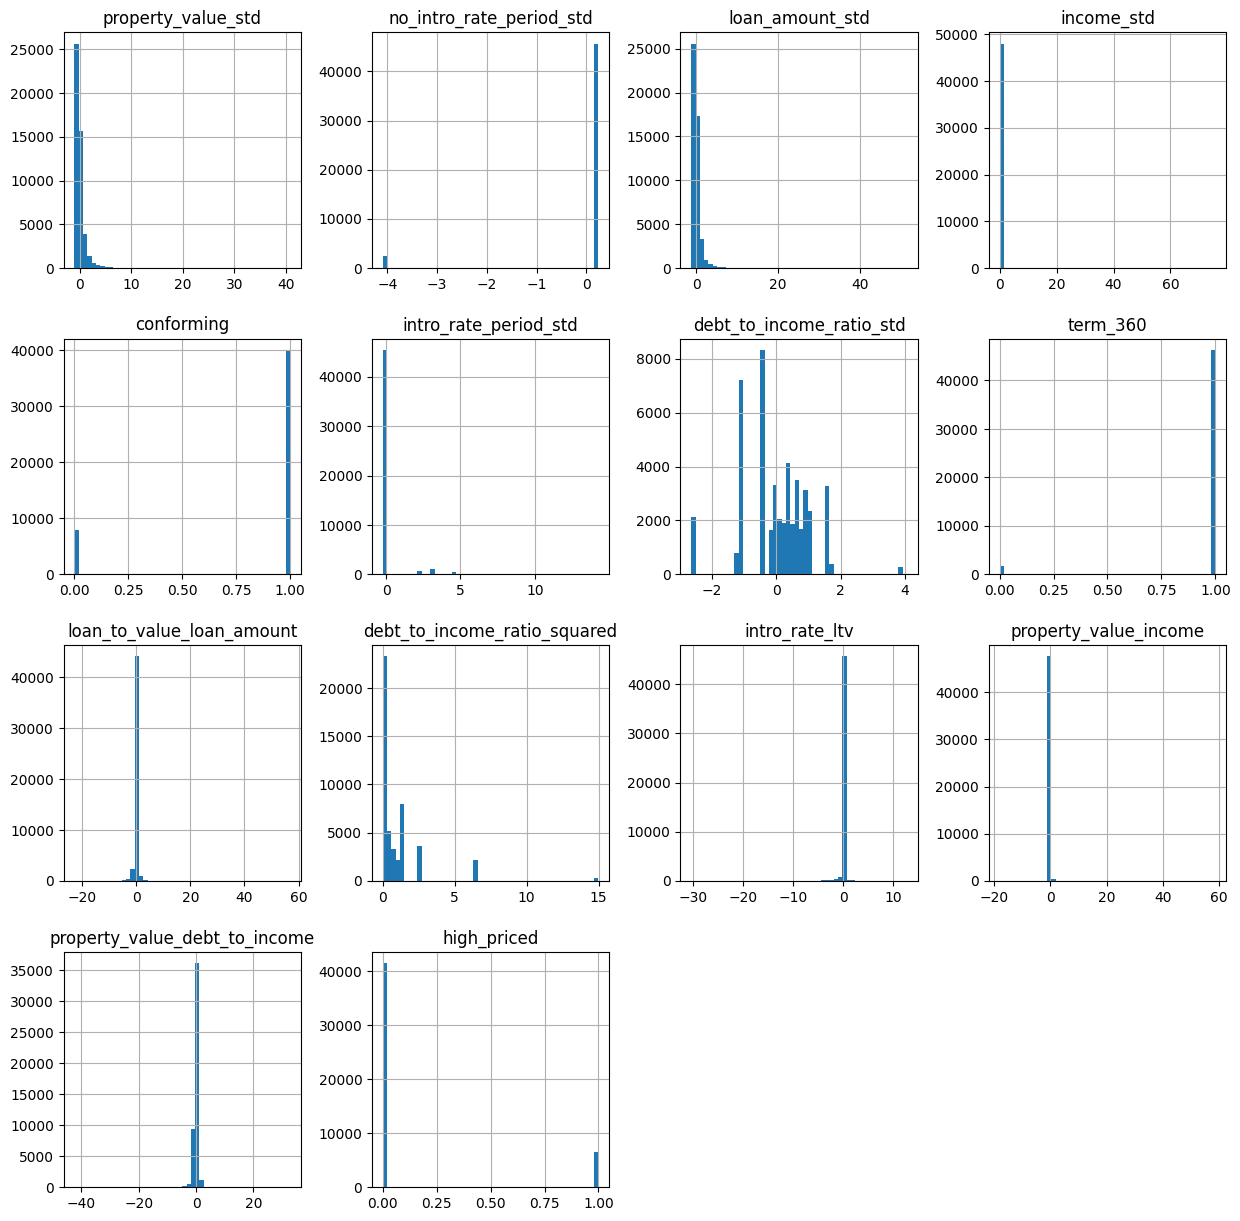

In [ ]:
np.random.seed(SEED)  # Ensure reproducibility

rec_valid = valid.copy(deep=True)  # Deep copy of validation data

# Add interaction terms to rec_valid to match rem_x_names
rec_valid['loan_to_value_loan_amount'] = rec_valid['loan_to_value_ratio_std'] * rec_valid['loan_amount_std']
rec_valid['debt_to_income_ratio_squared'] = rec_valid['debt_to_income_ratio_std'] ** 2
rec_valid['intro_rate_ltv'] = rec_valid['intro_rate_period_std'] * rec_valid['loan_to_value_ratio_std']
rec_valid['property_value_income'] = rec_valid['property_value_std'] * rec_valid['income_std']
rec_valid['property_value_debt_to_income'] = rec_valid['property_value_std'] * rec_valid['debt_to_income_ratio_std']

# Use severity variable to control how many customers are affected
severity = 0.1
affected = np.random.rand(len(rec_valid)) < severity

# Decrease property values by 5%
rec_valid.loc[affected, 'property_value_std'] = rec_valid.loc[affected, 'property_value_std'] * 0.95

# Less intro rates
rec_valid.loc[affected, 'no_intro_rate_period_std'] = 0.2443944

# Lower loan amounts by 5%
rec_valid.loc[affected, 'loan_amount_std'] = rec_valid.loc[affected, 'loan_amount_std'] * 0.95

# Lower income by 5%
rec_valid.loc[affected, 'income_std'] = rec_valid.loc[affected, 'income_std'] * 0.95

# Less conforming loans
rec_valid.loc[affected, 'conforming'] = 0

# Shorter intro rate periods
rec_valid.loc[affected, 'intro_rate_period_std'] = rec_valid.loc[affected, 'intro_rate_period_std'] * 0.95

# 5% higher debt-to-income ratios
rec_valid.loc[affected, 'debt_to_income_ratio_std'] = rec_valid.loc[affected, 'debt_to_income_ratio_std'] * 1.05

# More long loans
rec_valid.loc[affected, 'term_360'] = 1

# Update target: Randomly assign high_priced to simulate uncertainty
rec_valid.loc[affected, y_name] = np.random.choice(2, len(rec_valid.loc[affected, y_name]))

# Visualize results
_ = rec_valid[rem_x_names + [y_name]].hist(bins=50, figsize=(15, 15))

#### Find AUC for best model in simulated recession conditions

In [ ]:
rec_rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(rec_valid[rem_x_names], rec_valid[y_name])
rec_rem_auc = rec_rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rec_rem_auc)

Remediated EBM retrained with AUC: 0.6989.


Note the major drop in performance for recession conditions, which is normal for all models and usually worse for complex ML models. It's not unlikely that the more constrained monotonic GBM or penalized GLM could perform better in these conditions.

Also, this tells us we need to monitor this model carefully, because when recession conditions begin, this model will fail quickly.

## Residual Analysis

#### Calculate predictions and logloss residuals for all data

In [ ]:
# Shortcut names
yhat_name = 'phat'
r_name = 'r'

# Add interaction terms to data to match rem_x_names
data['loan_to_value_loan_amount'] = data['loan_to_value_ratio_std'] * data['loan_amount_std']
data['debt_to_income_ratio_squared'] = data['debt_to_income_ratio_std'] ** 2
data['intro_rate_ltv'] = data['intro_rate_period_std'] * data['loan_to_value_ratio_std']
data['property_value_income'] = data['property_value_std'] * data['income_std']
data['property_value_debt_to_income'] = data['property_value_std'] * data['debt_to_income_ratio_std']

# Calculate predictions
rem_ebm_phat = pd.DataFrame(rem_ebm.predict_proba(data[rem_x_names])[:, 1], columns=['phat'])
rem_ebm_phat = pd.concat([data.reset_index(drop=True), rem_ebm_phat], axis=1)

# Calculate logloss residuals
rem_ebm_phat[r_name] = -rem_ebm_phat[y_name]*np.log(rem_ebm_phat[yhat_name]) -\
                       (1 - rem_ebm_phat[y_name])*np.log(1 - rem_ebm_phat[yhat_name])

#### Plot residuals

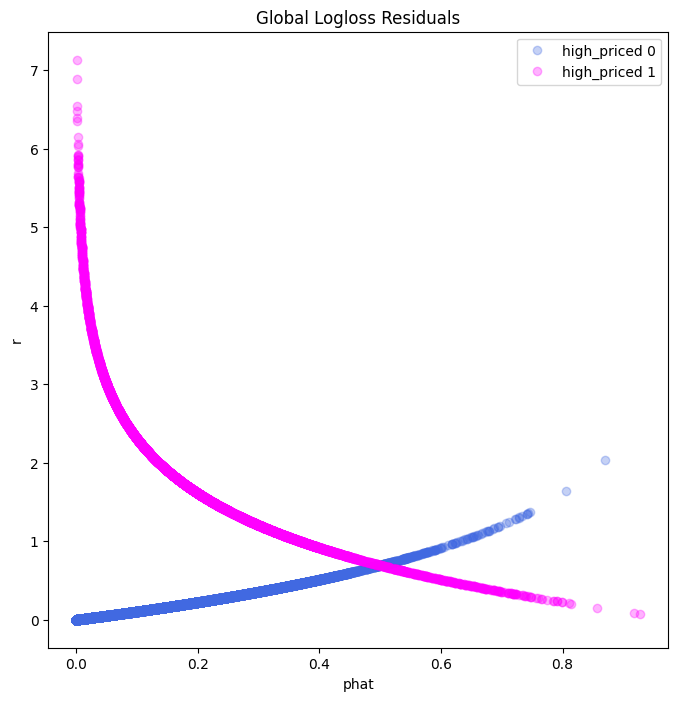

In [ ]:
# Initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))

# Plot groups with appropriate color
color_list = ['royalblue', 'magenta']
c_idx = 0
groups = rem_ebm_phat.groupby(y_name)
for name, group in groups:
    ax_.plot(group.phat, group.r,
             label=' '.join([y_name, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1

# Annotate plot
_ = plt.xlabel(yhat_name)
_ = plt.ylabel(r_name)
_ = ax_.legend(loc=1)
_ = plt.title('Global Logloss Residuals')

Residuals are very unbalanced. This model struggles to predict when customers will recieve a high-priced loan correctly. It does much better when predicting customers will NOT receive a high-priced loan. There are also some very noticable outliers.

## Remediation: Remove Outliers

#### Find outliers

In [ ]:
rem_ebm_phat.sort_values(by='r', ascending=False).head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,income_std,debt_to_income_ratio_std,high_priced,loan_to_value_loan_amount,debt_to_income_ratio_squared,intro_rate_ltv,property_value_income,property_value_debt_to_income,phat,r
143877,143877,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,-0.035110,1.037419,1,-0.302707,1.076239,0.073006,-0.029901,0.883500,0.000800,7.130464
71804,71804,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,-0.018133,0.214735,1,0.070313,0.046111,0.792620,-0.003701,0.043828,0.001027,6.881352
66704,66704,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,-0.012935,0.854601,1,0.216750,0.730342,4.312789,-0.005033,0.332534,0.001449,6.536802
144991,144991,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,-0.052781,-1.156406,1,0.681646,1.337275,0.383714,-0.020538,-0.449970,0.001539,6.476662
83113,83113,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.017208,-0.059493,1,-0.210766,0.003539,0.059646,0.012002,-0.041494,0.001683,6.387073


#### Remove worst outliers

In [ ]:
# Use a slightly lower n_remove to retain more data
n_remove = 90  # Reduced from 100

# Remove top n_remove outliers
rem_data = data.copy(deep=True)
outliers = list(rem_ebm_phat.sort_values(by='r', ascending=False).head(n=n_remove).index)
rem_data.drop(outliers, axis=0, inplace=True)

print(f'Removed {n_remove} outliers.')

Removed 90 outliers.


## Remediation: Down-sample to Increase Signal from High-priced Loans

In [ ]:
# Adjust inverse_proportion_remove to retain more data
inverse_proportion_remove = 3  # Less aggressive than 4

# Down-sample high_priced=0 rows
temp_data = rem_data.copy(deep=True)
indices_to_remove = list(temp_data[temp_data[y_name] == 0].index)[::inverse_proportion_remove]
temp_data.drop(indices_to_remove, axis=0, inplace=True)

rem_data_final = temp_data.copy(deep=True)
print(f'Down-sampled with inverse_proportion_remove={inverse_proportion_remove}.')

Down-sampled with inverse_proportion_remove=3.


#### Retrain remediated EBM

In [ ]:
np.random.seed(SEED)

# Use the best rem_data_final from down-sampling
rem_data = rem_data_final

# Execute final split
split = np.random.rand(len(rem_data)) < split_ratio
rem_train = rem_data[split].copy(deep=True)  # Create deep copy to avoid SettingWithCopyWarning
rem_valid = rem_data[~split].copy(deep=True)  # Create deep copy to avoid SettingWithCopyWarning

# Add interaction terms to rem_train and rem_valid
rem_train['loan_to_value_loan_amount'] = rem_train['loan_to_value_ratio_std'] * rem_train['loan_amount_std']
rem_valid['loan_to_value_loan_amount'] = rem_valid['loan_to_value_ratio_std'] * rem_valid['loan_amount_std']
rem_train['debt_to_income_ratio_squared'] = rem_train['debt_to_income_ratio_std'] ** 2
rem_valid['debt_to_income_ratio_squared'] = rem_valid['debt_to_income_ratio_std'] ** 2
rem_train['intro_rate_ltv'] = rem_train['intro_rate_period_std'] * rem_train['loan_to_value_ratio_std']
rem_valid['intro_rate_ltv'] = rem_valid['intro_rate_period_std'] * rem_valid['loan_to_value_ratio_std']
rem_train['property_value_income'] = rem_train['property_value_std'] * rem_train['income_std']
rem_valid['property_value_income'] = rem_valid['property_value_std'] * rem_valid['income_std']
rem_train['property_value_debt_to_income'] = rem_train['property_value_std'] * rem_train['debt_to_income_ratio_std']
rem_valid['property_value_debt_to_income'] = rem_valid['property_value_std'] * rem_valid['debt_to_income_ratio_std']

# Summarize split
print('Remediated train data rows = %d, columns = %d' % (rem_train.shape[0], rem_train.shape[1]))
print('Remediated validation data rows = %d, columns = %d' % (rem_valid.shape[0], rem_valid.shape[1]))

# Retrain final model
rem_ebm2 = ExplainableBoostingClassifier(**rem_params)
rem_ebm2.fit(rem_train[rem_x_names], rem_train[y_name])

# Evaluate on remediated validation set
rem_ebm_perf2 = ROC(rem_ebm2.predict_proba).explain_perf(rem_valid[rem_x_names], rem_valid[y_name])
rem_auc2 = rem_ebm_perf2._internal_obj['overall']['auc']
print('Remediated EBM under-sampled AUC: %.4f.' % rem_auc2)

Remediated train data rows = 78450, columns = 28
Remediated validation data rows = 33520, columns = 28
Remediated EBM under-sampled AUC: 0.8300.


#### Test remediated EBM on true validation data

In [ ]:
# Add interaction terms to the original validation set
valid_copy = valid.copy(deep=True)
valid_copy['loan_to_value_loan_amount'] = valid_copy['loan_to_value_ratio_std'] * valid_copy['loan_amount_std']
valid_copy['debt_to_income_ratio_squared'] = valid_copy['debt_to_income_ratio_std'] ** 2
valid_copy['intro_rate_ltv'] = valid_copy['intro_rate_period_std'] * valid_copy['loan_to_value_ratio_std']
valid_copy['property_value_income'] = valid_copy['property_value_std'] * valid_copy['income_std']
valid_copy['property_value_debt_to_income'] = valid_copy['property_value_std'] * valid_copy['debt_to_income_ratio_std']

# Calculate predictions using the base model (for comparison)
rem_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid_copy[rem_x_names])[:, 1], columns=['phat'])
rem_ebm_phat2 = pd.concat([valid_copy.reset_index(drop=True), rem_ebm_phat2], axis=1)

# Evaluate the remediated model on the true validation set
rem_ebm_perf3 = ROC(rem_ebm2.predict_proba).explain_perf(valid_copy[rem_x_names], valid_copy[y_name])
rem_auc3 = rem_ebm_perf3._internal_obj['overall']['auc']
print('Remediated EBM true AUC: %.4f.' % rem_auc3)

Remediated EBM true AUC: 0.8309.


Dropping outliers and under-sampling increases true AUC!

#### End global timer

In [ ]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 2100.84 s.
